<a href="https://colab.research.google.com/github/MPGarg/EVASub/blob/Session-5/EVA8_Assigment_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
from __future__ import print_function
import torch.optim as optim
from torchvision import datasets, transforms
import torch
import torch.nn.functional as F

# Import Model.py from Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Insert the directory
import sys
sys.path.insert(0,'/content/drive/My Drive/Colab Notebooks')

Net is class for model

In [5]:
import model
from model import Net

# Transformations

*   Image Normalization


In [6]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std  
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [7]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders


In [8]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
#Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create.
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


## Sample Images

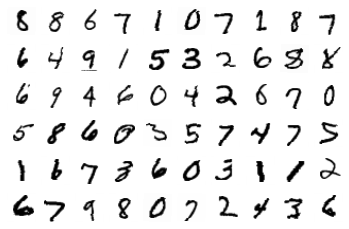

In [9]:
# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

dataiter = iter(train_loader)
images, labels = next(dataiter)

figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# Model Params
Visualization of Model Summary with Batch Normalization (without L1)

In [10]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net('BN').to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1

# Calculate Lambda for L1

In [11]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch,calc_l1=''):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  l1 = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    
    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    
    # Calculate L1 lambda
    if calc_l1 == 'X' and l1 == 0:        
        for p in model.parameters():
            l1 = l1 + p.abs().sum()
        print('Total of weights', l1)      

    train_losses.append(loss)
    
    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)


In [12]:
model =  Net('BN').to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 1
for epoch in range(EPOCHS):
    print("EPOCH:", epoch + 1 )
    train(model, device, train_loader, optimizer, epoch,'X')


EPOCH: 1


  0%|          | 0/469 [00:00<?, ?it/s]

Total of weights tensor(476.7276, device='cuda:0', grad_fn=<AddBackward0>)


Loss=0.18198049068450928 Batch_id=468 Accuracy=84.03: 100%|██████████| 469/469 [00:29<00:00, 15.87it/s]


# Training and Testing

In [13]:
wrong_pred_BN_w = []
wrong_pred_BN = []
wrong_pred_LN = []
wrong_pred_GN = []

In [17]:
#Initialize values for next 
train_losses = []
test_losses = []
train_acc = []
test_acc = []
wrong_pred = []

Defining Train & Test functions

In [57]:
from tqdm import tqdm
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch,lambda_l1=0):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  train_loss = 0
  
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    
    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)    

    l1 = 0
    if lambda_l1 > 0:
        for p in model.parameters():
            l1 = l1 + p.abs().sum()

    loss = loss + lambda_l1 * l1    
    
    train_loss += loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_losses.append(train_loss / len(train_loader.dataset))
  train_acc.append(100. * correct / len(train_loader.dataset))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))
    

Define function to display wrong prediction

In [15]:
import matplotlib.pyplot as plt

def display_incorrect_pred(mismatch, n=10 ):
    display_images = mismatch[:n]
    index = 0
    fig = plt.figure(figsize=(10,12))
    for img in display_images:
        image = img[0].squeeze().to('cpu').numpy()
        pred = img[1]
        actual = img[2]
        ax = fig.add_subplot(5, 2, index+1)
        ax.axis('off')
        ax.set_title(f'\n Predicted Label : {pred} \n Actual Label : {actual}',fontsize=10) 
        ax.imshow(image, cmap='gray_r')
        index = index + 1
    plt.show()

# Train and Test BN (without L1)

In [19]:
from torch.optim.lr_scheduler import StepLR

model =  Net('BN').to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=8, gamma=0.1)
EPOCHS = 20
lambda_l1 = 0

for epoch in range(EPOCHS):
    print("EPOCH:", epoch + 1 )
    train(model, device, train_loader, optimizer, epoch,lambda_l1)
    scheduler.step()
    test(model, device, test_loader)

#mismatch data
model.eval()
for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    output = model(data)
    pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    result = pred.eq(target.view_as(pred)).to('cpu').numpy()
    for j, i in enumerate(result):
      if(i == False):
        wrong_pred.append((data[j], pred[j].item(), target[j].item()))

EPOCH: 1


Loss=0.11505382508039474 Batch_id=468 Accuracy=92.85: 100%|██████████| 469/469 [00:30<00:00, 15.29it/s]



Test set: Average loss: 0.0775, Accuracy: 9751/10000 (97.51%)

EPOCH: 2


Loss=0.03603827580809593 Batch_id=468 Accuracy=97.85: 100%|██████████| 469/469 [00:30<00:00, 15.54it/s]



Test set: Average loss: 0.0516, Accuracy: 9839/10000 (98.39%)

EPOCH: 3


Loss=0.07357574254274368 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:30<00:00, 15.42it/s]



Test set: Average loss: 0.0305, Accuracy: 9908/10000 (99.08%)

EPOCH: 4


Loss=0.03535250574350357 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:30<00:00, 15.58it/s]



Test set: Average loss: 0.0266, Accuracy: 9911/10000 (99.11%)

EPOCH: 5


Loss=0.04162443429231644 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:32<00:00, 14.65it/s]



Test set: Average loss: 0.0238, Accuracy: 9936/10000 (99.36%)

EPOCH: 6


Loss=0.02541748434305191 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:30<00:00, 15.60it/s]



Test set: Average loss: 0.0249, Accuracy: 9924/10000 (99.24%)

EPOCH: 7


Loss=0.00928970891982317 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:30<00:00, 15.51it/s]



Test set: Average loss: 0.0230, Accuracy: 9929/10000 (99.29%)

EPOCH: 8


Loss=0.019410161301493645 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:30<00:00, 15.47it/s]



Test set: Average loss: 0.0210, Accuracy: 9929/10000 (99.29%)

EPOCH: 9


Loss=0.031148694455623627 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:30<00:00, 15.47it/s]



Test set: Average loss: 0.0174, Accuracy: 9950/10000 (99.50%)

EPOCH: 10


Loss=0.04410099610686302 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:30<00:00, 15.56it/s]



Test set: Average loss: 0.0169, Accuracy: 9949/10000 (99.49%)

EPOCH: 11


Loss=0.0056610554456710815 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:29<00:00, 15.75it/s]



Test set: Average loss: 0.0174, Accuracy: 9948/10000 (99.48%)

EPOCH: 12


Loss=0.009352454915642738 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:31<00:00, 14.83it/s]



Test set: Average loss: 0.0176, Accuracy: 9947/10000 (99.47%)

EPOCH: 13


Loss=0.0018564051715657115 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:30<00:00, 15.46it/s]



Test set: Average loss: 0.0172, Accuracy: 9945/10000 (99.45%)

EPOCH: 14


Loss=0.011025474406778812 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:29<00:00, 15.67it/s]



Test set: Average loss: 0.0174, Accuracy: 9945/10000 (99.45%)

EPOCH: 15


Loss=0.003721078159287572 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:30<00:00, 15.55it/s]



Test set: Average loss: 0.0173, Accuracy: 9942/10000 (99.42%)

EPOCH: 16


Loss=0.0781835988163948 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:30<00:00, 15.48it/s]



Test set: Average loss: 0.0176, Accuracy: 9949/10000 (99.49%)

EPOCH: 17


Loss=0.02359369397163391 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:30<00:00, 15.49it/s]



Test set: Average loss: 0.0173, Accuracy: 9951/10000 (99.51%)

EPOCH: 18


Loss=0.048965077847242355 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:32<00:00, 14.25it/s]



Test set: Average loss: 0.0170, Accuracy: 9946/10000 (99.46%)

EPOCH: 19


Loss=0.015846477821469307 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:34<00:00, 13.78it/s]



Test set: Average loss: 0.0173, Accuracy: 9947/10000 (99.47%)

EPOCH: 20


Loss=0.010871666483581066 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:30<00:00, 15.50it/s]



Test set: Average loss: 0.0174, Accuracy: 9946/10000 (99.46%)



In [20]:
#Values of BN Losses (without L1)
train_losses_BN_w = train_losses
test_losses_BN_w = test_losses
train_acc_BN_w = train_acc
test_acc_BN_w = test_acc
wrong_pred_BN_w = wrong_pred

In [60]:
#Initialize values for next 
train_losses = []
test_losses = []
train_acc = []
test_acc = []
wrong_pred = []

Display wrong prediction for BN without L1

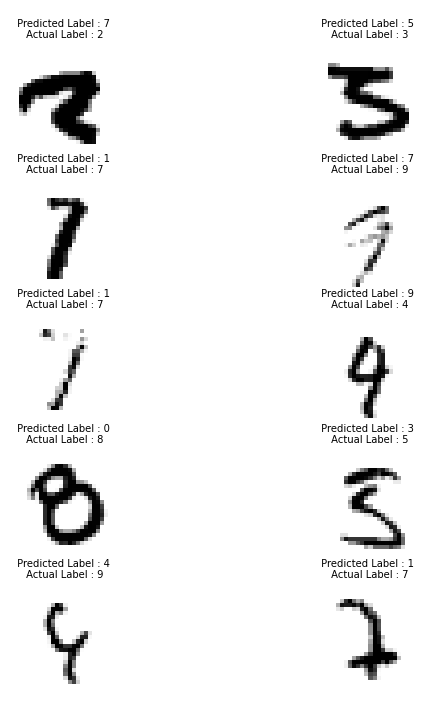

In [22]:
display_incorrect_pred(wrong_pred_BN_w)

# Train and Test BN (with L1)

In [61]:
from torch.optim.lr_scheduler import StepLR

model =  Net('BN').to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=8, gamma=0.1)
EPOCHS = 20
#Approximated from above calculation for 1 epoch

lambda_l1 = 0.0001

for epoch in range(EPOCHS):
    print("EPOCH:", epoch + 1 )
    train(model, device, train_loader, optimizer, epoch,lambda_l1)
    scheduler.step()
    test(model, device, test_loader)

#mismatch data
model.eval()
for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    output = model(data)
    pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    result = pred.eq(target.view_as(pred)).to('cpu').numpy()
    for j, i in enumerate(result):
      if(i == False):
        wrong_pred.append((data[j], pred[j].item(), target[j].item()))

EPOCH: 1


Loss=0.1539936065673828 Batch_id=468 Accuracy=92.27: 100%|██████████| 469/469 [00:29<00:00, 15.85it/s]



Test set: Average loss: 0.0769, Accuracy: 9753/10000 (97.53%)

EPOCH: 2


Loss=0.14583952724933624 Batch_id=468 Accuracy=97.44: 100%|██████████| 469/469 [00:31<00:00, 14.93it/s]



Test set: Average loss: 0.0456, Accuracy: 9860/10000 (98.60%)

EPOCH: 3


Loss=0.3438575565814972 Batch_id=468 Accuracy=97.83: 100%|██████████| 469/469 [00:29<00:00, 15.67it/s]



Test set: Average loss: 0.0639, Accuracy: 9784/10000 (97.84%)

EPOCH: 4


Loss=0.1380782574415207 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:29<00:00, 15.68it/s]



Test set: Average loss: 0.0530, Accuracy: 9838/10000 (98.38%)

EPOCH: 5


Loss=0.09569372236728668 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:30<00:00, 15.62it/s]



Test set: Average loss: 0.0459, Accuracy: 9861/10000 (98.61%)

EPOCH: 6


Loss=0.15636113286018372 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:29<00:00, 15.68it/s]



Test set: Average loss: 0.0389, Accuracy: 9864/10000 (98.64%)

EPOCH: 7


Loss=0.2154151052236557 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:29<00:00, 15.79it/s]



Test set: Average loss: 0.0309, Accuracy: 9906/10000 (99.06%)

EPOCH: 8


Loss=0.10951393097639084 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:29<00:00, 15.74it/s]



Test set: Average loss: 0.0315, Accuracy: 9894/10000 (98.94%)

EPOCH: 9


Loss=0.12441205978393555 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:29<00:00, 15.77it/s]



Test set: Average loss: 0.0215, Accuracy: 9934/10000 (99.34%)

EPOCH: 10


Loss=0.08479209244251251 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:30<00:00, 15.61it/s]



Test set: Average loss: 0.0194, Accuracy: 9940/10000 (99.40%)

EPOCH: 11


Loss=0.08868466317653656 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:29<00:00, 15.69it/s]



Test set: Average loss: 0.0197, Accuracy: 9942/10000 (99.42%)

EPOCH: 12


Loss=0.1563335806131363 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:29<00:00, 15.66it/s]



Test set: Average loss: 0.0205, Accuracy: 9936/10000 (99.36%)

EPOCH: 13


Loss=0.12033867835998535 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:30<00:00, 15.45it/s]



Test set: Average loss: 0.0183, Accuracy: 9939/10000 (99.39%)

EPOCH: 14


Loss=0.10723528265953064 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:30<00:00, 15.37it/s]



Test set: Average loss: 0.0183, Accuracy: 9940/10000 (99.40%)

EPOCH: 15


Loss=0.11651232838630676 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:30<00:00, 15.33it/s]



Test set: Average loss: 0.0202, Accuracy: 9931/10000 (99.31%)

EPOCH: 16


Loss=0.09187396615743637 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:30<00:00, 15.19it/s]



Test set: Average loss: 0.0200, Accuracy: 9938/10000 (99.38%)

EPOCH: 17


Loss=0.08531280606985092 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:30<00:00, 15.51it/s]



Test set: Average loss: 0.0187, Accuracy: 9939/10000 (99.39%)

EPOCH: 18


Loss=0.07951941341161728 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:30<00:00, 15.43it/s]



Test set: Average loss: 0.0189, Accuracy: 9942/10000 (99.42%)

EPOCH: 19


Loss=0.10270266234874725 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:32<00:00, 14.61it/s]



Test set: Average loss: 0.0183, Accuracy: 9945/10000 (99.45%)

EPOCH: 20


Loss=0.0748690590262413 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:30<00:00, 15.35it/s]



Test set: Average loss: 0.0183, Accuracy: 9943/10000 (99.43%)



In [65]:
#Values of BN Losses
train_losses_BN = train_losses
test_losses_BN = test_losses
train_acc_BN = train_acc
test_acc_BN = test_acc
wrong_pred_BN = wrong_pred

In [25]:
#Initialize values for next 
train_losses = []
test_losses = []
train_acc = []
test_acc = []
wrong_pred = []

Display wrong prediction for BN with L1

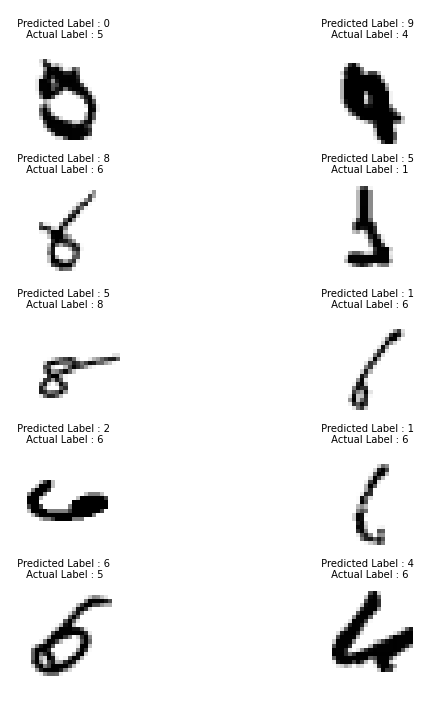

In [66]:
display_incorrect_pred(wrong_pred_BN)

# Train and Test for LN

In [27]:
model = Net('LN').to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
         GroupNorm-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
         GroupNorm-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0
        GroupNorm-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1, 16,

In [28]:
model =  Net('LN').to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=8, gamma=0.1)
EPOCHS = 20
lambda_l1 = 0

for epoch in range(EPOCHS):
    print("EPOCH:", epoch + 1 )
    train(model, device, train_loader, optimizer, epoch,lambda_l1)
    scheduler.step()
    test(model, device, test_loader)

#mismatch data
model.eval()
for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    output = model(data)
    pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    result = pred.eq(target.view_as(pred)).to('cpu').numpy()
    for j, i in enumerate(result):
      if(i == False):
        wrong_pred.append((data[j], pred[j].item(), target[j].item()))

EPOCH: 1


Loss=0.07911201566457748 Batch_id=468 Accuracy=88.53: 100%|██████████| 469/469 [00:29<00:00, 15.81it/s]



Test set: Average loss: 0.0688, Accuracy: 9786/10000 (97.86%)

EPOCH: 2


Loss=0.028871407732367516 Batch_id=468 Accuracy=97.11: 100%|██████████| 469/469 [00:29<00:00, 15.75it/s]



Test set: Average loss: 0.0609, Accuracy: 9804/10000 (98.04%)

EPOCH: 3


Loss=0.021422231569886208 Batch_id=468 Accuracy=97.83: 100%|██████████| 469/469 [00:29<00:00, 15.78it/s]



Test set: Average loss: 0.0536, Accuracy: 9837/10000 (98.37%)

EPOCH: 4


Loss=0.19379259645938873 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:29<00:00, 15.78it/s]



Test set: Average loss: 0.0533, Accuracy: 9839/10000 (98.39%)

EPOCH: 5


Loss=0.030839739367365837 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:29<00:00, 15.71it/s]



Test set: Average loss: 0.0325, Accuracy: 9898/10000 (98.98%)

EPOCH: 6


Loss=0.03518823906779289 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:29<00:00, 15.84it/s]



Test set: Average loss: 0.0386, Accuracy: 9881/10000 (98.81%)

EPOCH: 7


Loss=0.04108927771449089 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:29<00:00, 15.82it/s]



Test set: Average loss: 0.0272, Accuracy: 9917/10000 (99.17%)

EPOCH: 8


Loss=0.02330348640680313 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:31<00:00, 14.95it/s]



Test set: Average loss: 0.0297, Accuracy: 9911/10000 (99.11%)

EPOCH: 9


Loss=0.027553759515285492 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:29<00:00, 15.70it/s]



Test set: Average loss: 0.0213, Accuracy: 9928/10000 (99.28%)

EPOCH: 10


Loss=0.025057971477508545 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:29<00:00, 15.72it/s]



Test set: Average loss: 0.0203, Accuracy: 9931/10000 (99.31%)

EPOCH: 11


Loss=0.029771069064736366 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:29<00:00, 15.71it/s]



Test set: Average loss: 0.0201, Accuracy: 9936/10000 (99.36%)

EPOCH: 12


Loss=0.008515425957739353 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:29<00:00, 15.68it/s]



Test set: Average loss: 0.0196, Accuracy: 9937/10000 (99.37%)

EPOCH: 13


Loss=0.05317508801817894 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:29<00:00, 15.80it/s]



Test set: Average loss: 0.0199, Accuracy: 9942/10000 (99.42%)

EPOCH: 14


Loss=0.011626794934272766 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:29<00:00, 15.79it/s]



Test set: Average loss: 0.0183, Accuracy: 9943/10000 (99.43%)

EPOCH: 15


Loss=0.020251473411917686 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:31<00:00, 15.08it/s]



Test set: Average loss: 0.0204, Accuracy: 9938/10000 (99.38%)

EPOCH: 16


Loss=0.034938305616378784 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:29<00:00, 16.04it/s]



Test set: Average loss: 0.0212, Accuracy: 9935/10000 (99.35%)

EPOCH: 17


Loss=0.04433046281337738 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:29<00:00, 16.09it/s]



Test set: Average loss: 0.0190, Accuracy: 9941/10000 (99.41%)

EPOCH: 18


Loss=0.005895477253943682 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:29<00:00, 15.79it/s]



Test set: Average loss: 0.0189, Accuracy: 9941/10000 (99.41%)

EPOCH: 19


Loss=0.027553951367735863 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:29<00:00, 15.88it/s]



Test set: Average loss: 0.0191, Accuracy: 9940/10000 (99.40%)

EPOCH: 20


Loss=0.043873220682144165 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:29<00:00, 15.92it/s]



Test set: Average loss: 0.0189, Accuracy: 9942/10000 (99.42%)



In [29]:
#Values of LN Losses
train_losses_LN = train_losses
test_losses_LN = test_losses
train_acc_LN = train_acc
test_acc_LN = test_acc
wrong_pred_LN = wrong_pred

In [30]:
#Initialize values for next 
train_losses = []
test_losses = []
train_acc = []
test_acc = []
wrong_pred = []

Display wrong prediction for LN

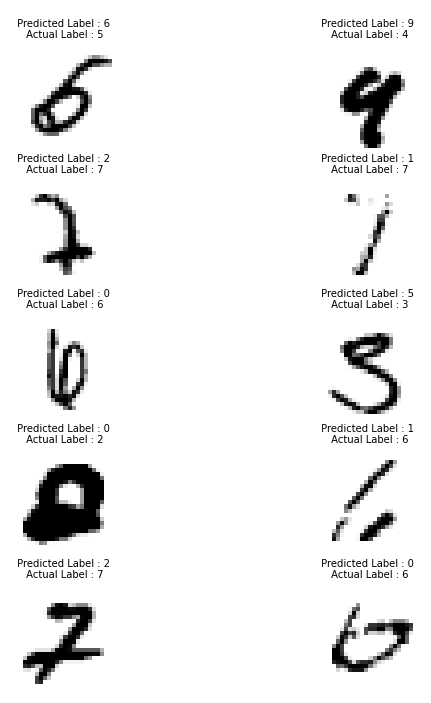

In [31]:
display_incorrect_pred(wrong_pred_LN)

# Train and Test for GN

In [32]:
model = Net('GN').to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
         GroupNorm-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
         GroupNorm-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0
        GroupNorm-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1, 16,

In [33]:
model =  Net('GN').to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=8, gamma=0.1)
EPOCHS = 20
lambda_l1 = 0

for epoch in range(EPOCHS):
    print("EPOCH:", epoch + 1 )
    train(model, device, train_loader, optimizer, epoch,lambda_l1)
    scheduler.step()
    test(model, device, test_loader)

#mismatch data
model.eval()
for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    output = model(data)
    pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    result = pred.eq(target.view_as(pred)).to('cpu').numpy()
    for j, i in enumerate(result):
      if(i == False):
        wrong_pred.append((data[j], pred[j].item(), target[j].item()))

EPOCH: 1


Loss=0.0859915241599083 Batch_id=468 Accuracy=85.65: 100%|██████████| 469/469 [00:29<00:00, 16.07it/s]



Test set: Average loss: 0.1179, Accuracy: 9630/10000 (96.30%)

EPOCH: 2


Loss=0.0777672529220581 Batch_id=468 Accuracy=96.98: 100%|██████████| 469/469 [00:30<00:00, 15.17it/s]



Test set: Average loss: 0.0673, Accuracy: 9792/10000 (97.92%)

EPOCH: 3


Loss=0.055962368845939636 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:29<00:00, 15.93it/s]



Test set: Average loss: 0.0387, Accuracy: 9875/10000 (98.75%)

EPOCH: 4


Loss=0.03974487632513046 Batch_id=468 Accuracy=98.07: 100%|██████████| 469/469 [00:29<00:00, 15.92it/s]



Test set: Average loss: 0.0507, Accuracy: 9842/10000 (98.42%)

EPOCH: 5


Loss=0.08090879023075104 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:29<00:00, 16.16it/s]



Test set: Average loss: 0.0449, Accuracy: 9863/10000 (98.63%)

EPOCH: 6


Loss=0.1661641150712967 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:29<00:00, 16.03it/s]



Test set: Average loss: 0.0269, Accuracy: 9907/10000 (99.07%)

EPOCH: 7


Loss=0.03867771476507187 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:29<00:00, 15.99it/s]



Test set: Average loss: 0.0309, Accuracy: 9902/10000 (99.02%)

EPOCH: 8


Loss=0.11725697666406631 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:29<00:00, 15.98it/s]



Test set: Average loss: 0.0281, Accuracy: 9917/10000 (99.17%)

EPOCH: 9


Loss=0.016256162896752357 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:30<00:00, 15.21it/s]



Test set: Average loss: 0.0231, Accuracy: 9920/10000 (99.20%)

EPOCH: 10


Loss=0.005298264790326357 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:29<00:00, 16.00it/s]



Test set: Average loss: 0.0237, Accuracy: 9920/10000 (99.20%)

EPOCH: 11


Loss=0.016881829127669334 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:29<00:00, 16.17it/s]



Test set: Average loss: 0.0252, Accuracy: 9918/10000 (99.18%)

EPOCH: 12


Loss=0.014970708638429642 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:29<00:00, 15.93it/s]



Test set: Average loss: 0.0227, Accuracy: 9922/10000 (99.22%)

EPOCH: 13


Loss=0.059516116976737976 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:29<00:00, 16.10it/s]



Test set: Average loss: 0.0227, Accuracy: 9922/10000 (99.22%)

EPOCH: 14


Loss=0.006296529900282621 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:29<00:00, 15.98it/s]



Test set: Average loss: 0.0231, Accuracy: 9927/10000 (99.27%)

EPOCH: 15


Loss=0.014013082720339298 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:29<00:00, 16.09it/s]



Test set: Average loss: 0.0213, Accuracy: 9924/10000 (99.24%)

EPOCH: 16


Loss=0.009436030872166157 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:29<00:00, 16.14it/s]



Test set: Average loss: 0.0231, Accuracy: 9924/10000 (99.24%)

EPOCH: 17


Loss=0.05330706015229225 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:31<00:00, 15.01it/s]



Test set: Average loss: 0.0217, Accuracy: 9929/10000 (99.29%)

EPOCH: 18


Loss=0.02552572637796402 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:29<00:00, 15.80it/s]



Test set: Average loss: 0.0217, Accuracy: 9927/10000 (99.27%)

EPOCH: 19


Loss=0.030266448855400085 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:29<00:00, 15.99it/s]



Test set: Average loss: 0.0214, Accuracy: 9926/10000 (99.26%)

EPOCH: 20


Loss=0.027190759778022766 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:29<00:00, 15.87it/s]



Test set: Average loss: 0.0214, Accuracy: 9926/10000 (99.26%)



In [34]:
#Values of GN Losses
train_losses_GN = train_losses
test_losses_GN = test_losses
train_acc_GN = train_acc
test_acc_GN = test_acc
wrong_pred_GN = wrong_pred

Display wrong prediction for GN

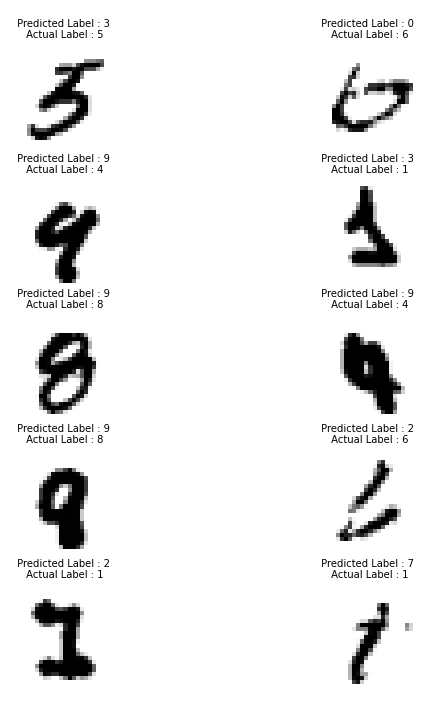

In [35]:
display_incorrect_pred(wrong_pred_GN)

# Display Validation Accuracy & Loss

In [67]:
#Multiplying by batch size to scale
train_losses_BN_w2 = [value * 128 for value in train_losses_BN_w]
train_losses_BN2 = [value * 128 for value in train_losses_BN]
train_losses_LN2 = [value * 128 for value in train_losses_LN]
train_losses_GN2 = [value * 128 for value in train_losses_GN]

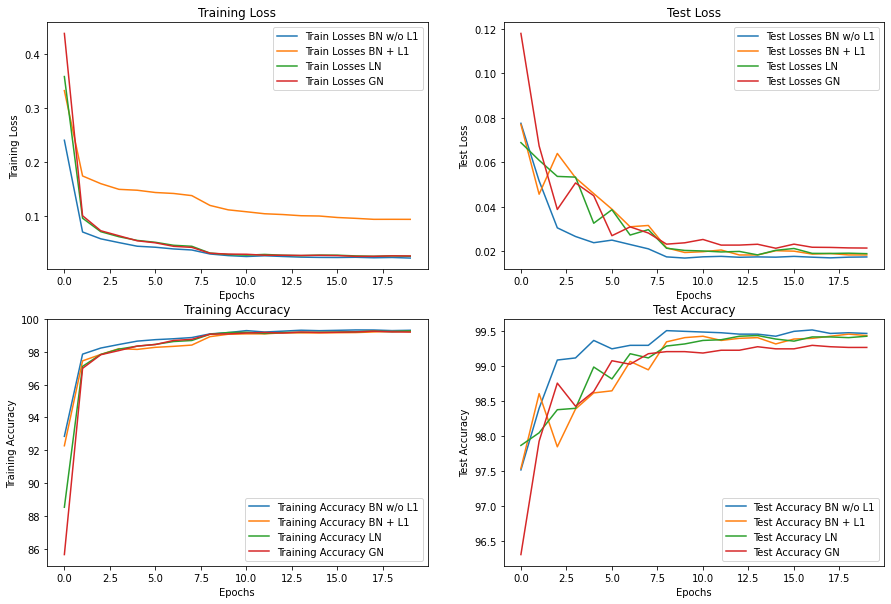

In [68]:
fig, axs = plt.subplots(2,2,figsize=(15,10))

axs[0, 0].plot(train_losses_BN_w2, label='Train Losses BN w/o L1')
axs[0, 0].plot(train_losses_BN2, label='Train Losses BN + L1')
axs[0, 0].plot(train_losses_LN2, label='Train Losses LN')
axs[0, 0].plot(train_losses_GN2, label='Train Losses GN')
axs[0,0].legend(loc='upper right')
axs[0,0].set_xlabel('Epochs')
axs[0,0].set_ylabel('Training Loss')
axs[0, 0].set_title("Training Loss")

axs[1, 0].plot(train_acc_BN_w, label='Training Accuracy BN w/o L1')
axs[1, 0].plot(train_acc_BN, label='Training Accuracy BN + L1')
axs[1, 0].plot(train_acc_LN, label='Training Accuracy LN')
axs[1, 0].plot(train_acc_GN, label='Training Accuracy GN')
axs[1,0].legend(loc='lower right')
axs[1,0].set_xlabel('Epochs')
axs[1,0].set_ylabel('Training Accuracy')
axs[1, 0].set_title("Training Accuracy")

axs[0, 1].plot(test_losses_BN_w, label='Test Losses BN w/o L1')
axs[0, 1].plot(test_losses_BN, label='Test Losses BN + L1')
axs[0, 1].plot(test_losses_LN, label='Test Losses LN')
axs[0, 1].plot(test_losses_GN, label='Test Losses GN')
axs[0,1].legend(loc='upper right')
axs[0,1].set_xlabel('Epochs')
axs[0,1].set_ylabel('Test Loss')
axs[0, 1].set_title("Test Loss")

axs[1, 1].plot(test_acc_BN_w, label='Test Accuracy BN w/o L1')
axs[1, 1].plot(test_acc_BN, label='Test Accuracy BN + L1')
axs[1, 1].plot(test_acc_LN, label='Test Accuracy LN')
axs[1, 1].plot(test_acc_GN, label='Test Accuracy GN')
axs[1,1].legend(loc='lower right')
axs[1,1].set_xlabel('Epochs')
axs[1,1].set_ylabel('Test Accuracy')
axs[1, 1].set_title("Test Accuracy")

plt.show()

# Comparing BN+L1, LN, GN

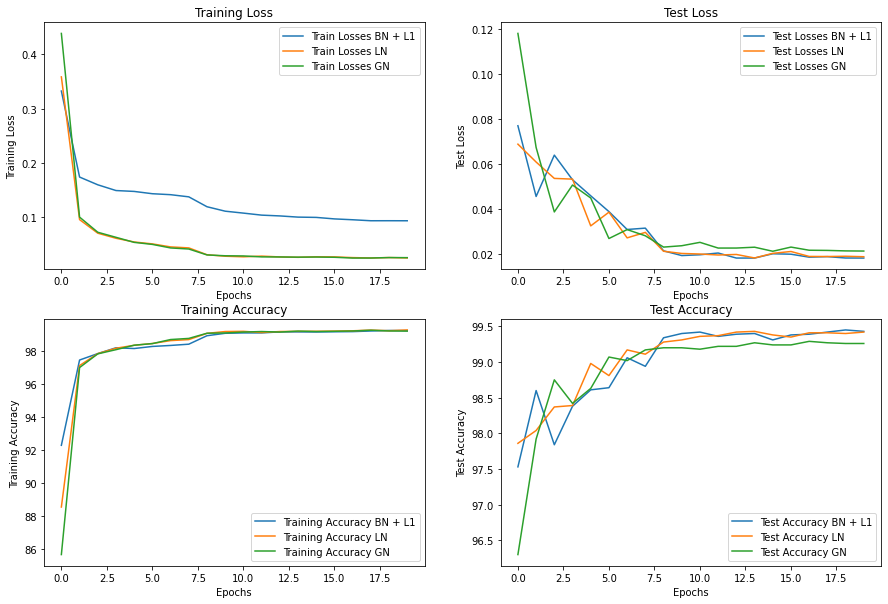

In [69]:
fig, axs = plt.subplots(2,2,figsize=(15,10))

axs[0, 0].plot(train_losses_BN2, label='Train Losses BN + L1')
axs[0, 0].plot(train_losses_LN2, label='Train Losses LN')
axs[0, 0].plot(train_losses_GN2, label='Train Losses GN')
axs[0,0].legend(loc='upper right')
axs[0,0].set_xlabel('Epochs')
axs[0,0].set_ylabel('Training Loss')
axs[0, 0].set_title("Training Loss")

axs[1, 0].plot(train_acc_BN, label='Training Accuracy BN + L1')
axs[1, 0].plot(train_acc_LN, label='Training Accuracy LN')
axs[1, 0].plot(train_acc_GN, label='Training Accuracy GN')
axs[1,0].legend(loc='lower right')
axs[1,0].set_xlabel('Epochs')
axs[1,0].set_ylabel('Training Accuracy')
axs[1, 0].set_title("Training Accuracy")

axs[0, 1].plot(test_losses_BN, label='Test Losses BN + L1')
axs[0, 1].plot(test_losses_LN, label='Test Losses LN')
axs[0, 1].plot(test_losses_GN, label='Test Losses GN')
axs[0,1].legend(loc='upper right')
axs[0,1].set_xlabel('Epochs')
axs[0,1].set_ylabel('Test Loss')
axs[0, 1].set_title("Test Loss")

axs[1, 1].plot(test_acc_BN, label='Test Accuracy BN + L1')
axs[1, 1].plot(test_acc_LN, label='Test Accuracy LN')
axs[1, 1].plot(test_acc_GN, label='Test Accuracy GN')
axs[1,1].legend(loc='lower right')
axs[1,1].set_xlabel('Epochs')
axs[1,1].set_ylabel('Test Accuracy')
axs[1, 1].set_title("Test Accuracy")

plt.show()